In [147]:
### IMPORTS ###
import scipy.sparse
import scipy.stats
import numpy as np
import matplotlib.pyplot as pyplot
import sklearn.metrics as mtc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from pyemd import emd
import valores
import pickle
import time

In [148]:
from __future__ import print_function
import keras
from keras.datasets import fashion_mnist  # new with Keras 2.1.2.  Yah!!
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,GaussianNoise
import keras.layers
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import sparse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

In [163]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Matriz de confusión',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(35, 26.25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=22)
        plt.yticks(tick_marks, target_names,fontsize=22)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Etiquetas verdaderas',fontsize=25)
    plt.xlabel('Etiquetas clasificadas',fontsize=25)
    plt.show()

In [161]:
## FUNCIONES ##


class TFM:

    def __init__(self,path):
        self.X_tr = scipy.sparse.load_npz(path+'X_tr.npz')
        self.X_tst = scipy.sparse.load_npz(path+'X_tst.npz')
        self.y_tr = np.load(path+'y_tr.npy')
        self.y_tst = np.load(path+'y_tst.npy')
        # Se binarizan las caracteristicas
        self.Mlb=MultiLabelBinarizer().fit(self.y_tr)
        self.y_tr=self.Mlb.transform(self.y_tr)
        self.y_tst=self.Mlb.transform(self.y_tst)
        # Escalado 
        scaler = MaxAbsScaler().fit(self.X_tr)
        self.X_tr=scaler.transform(self.X_tr)
        self.X_tst=scaler.transform(self.X_tst)
        self.X_tr_simpli= None
        self.modelo = None
        self.clf= None
        self.columns= None
        print ('Dataset cargado y preprocesado')

    def reduce_features(self,num_data):
        columns=np.array([])
        for i in range(np.shape(self.X_tr)[1]):
            if self.X_tr[:,i].count_nonzero()> num_data:
                columns=np.append(columns,i)
        np.savetxt('./features/features'+num_data+'.txt',columns,delimiter=',')
        print('Las características han sido reducidas')

    def simplify_dataset(self,features,tr_size):
        self.X_tr_simpli=self.X_tr
        self.y_tr_simpli=self.y_tr
        
        self.columns=np.loadtxt('./features/features'+features+'.txt',delimiter=',')
        self.X_tr_simpli=self.X_tr[:,self.columns]
        self.X_tr_simpli, __, self.y_tr_simpli, __ = train_test_split(self.X_tr_simpli, self.y_tr_simpli, test_size=(1-tr_size), random_state=42)
        print('Simplificación finalizada')
        print(np.shape(self.X_tr_simpli))
        
    def grid_search_cv(self,classifier,parameters,metodo):
        if (metodo == 0):
            classif = OneVsRestClassifier(classifier)
        elif (metodo==1):
            classif = ClassifierChain(classifier)
        model_tunning = GridSearchCV(classif, param_grid=parameters,cv=4,verbose=50, n_jobs=-1,scoring='accuracy')
        model_tunning.fit(self.X_tr_simpli, self.y_tr_simpli)
        print (model_tunning.best_score_)
        print (model_tunning.best_params_)
        self.modelo = model_tunning.best_estimator_

    def fitting_classifier(self):
        self.clf=self.modelo.fit(self.X_tr,self.y_tr)

    def pred_metr(self):
        self.y_pred=self.clf.predict(self.X_tst)
        self.metrics()
        
    def metrics(self):
        accuracy=mtc.accuracy_score(self.y_tst,self.y_pred)
        hamming=mtc.hamming_loss(self.y_tst,self.y_pred)
        precision=mtc.precision_score(self.y_tst,self.y_pred,average='micro')
        print("Total accuracy: ", accuracy)
        print("Hamming loss: ", hamming)
        aux=0
        for i in range(np.shape(self.y_pred)[1]):
            aux=aux+mtc.accuracy_score(self.y_tst[:,i],self.y_pred[:,i])
        print("Accuracy media: ",aux/37)
        distance_matrix=np.ones((37,37))*(1/37)
        np.fill_diagonal(distance_matrix,0)
        emd_aux=0
        for i in range (np.shape(self.y_tst)[0]):
            emd_aux= emd_aux + emd(self.y_tst[i,:].astype(float),self.y_pred[i,:].astype(float),distance_matrix)
        
        print("EMD: ", emd_aux/(np.shape(self.y_tst)[0]))
        
    def dnn(self,batch,epochs):
        num_classes = 37
        batch_size = batch
        epochs = epochs
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 3)
        filepath1="./nn/weights.best.acc.hdf5"
        filepath2="./nn/weights.best.loss.hdf5"
        checkpointacc = ModelCheckpoint(filepath1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        checkpointloss = ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpointacc,checkpointloss,es]
        self.model = Sequential()
        input_shape=(np.shape(self.X_tr)[1],)
        self.model.add(Dense(200, activation='relu',input_shape=input_shape))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(num_classes, activation='sigmoid'))
        print(self.model.summary())
        self.model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
        #self.model.load_weights("./nn/weights.best.acc.hdf5")
        hist = self.model.fit(self.X_tr, self.y_tr,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(self.X_tst, self.y_tst),callbacks=callbacks_list)
        self.y_pred = self.model.predict(self.X_tst)
        self.y_pred[self.y_pred>=0.5] = 1
        self.y_pred[self.y_pred<0.5] = 0
        self.metrics()

    
    def multilabelconfussion(self):
        self.testlabels=self.Mlb.inverse_transform(self.y_tst)
        self.predlabels=self.Mlb.inverse_transform(self.y_pred)
        cf=np.zeros((38,38))
        for pos1,i in enumerate(self.testlabels):
            auxlist1=list(self.testlabels[pos1])
            auxlist2=list(self.predlabels[pos1])
            for pos2,j in enumerate(self.testlabels[pos1]):
                if j in list(self.predlabels[pos1]):
                    cf[j,j]=cf[j,j]+1
                    auxlist1.remove(j)
                    auxlist2.remove(j)
            if not auxlist1:
                if not auxlist2:
                    continue
                else:
                    for pos2,j in enumerate(auxlist2):
                        cf[37,j]=cf[37,j]+1/len(auxlist2)
            else:
                if not auxlist2:
                    for pos2,j in enumerate(auxlist1):
                        cf[j,37]=cf[j,37]+1
                else:
                    for pos2,j in enumerate(auxlist1):
                        for pos3,k in enumerate(auxlist2):
                            cf[j,k]=cf[j,k]+1/len(auxlist2)
        return cf

In [136]:
path_string=input('Introduce el directorio del dataset')
clasificacion=TFM(path_string)
print('Inicio del programa clasificador')

while True:
    clasi_mode=int(input('Vas a usar clasificación lineal o redes neuronales:'))
    if (clasi_mode==0):
        clasi_type=int(input('Que clasificador vas a usar?: '))
        clasificador=valores.clasificadores_dict[clasi_type]
        metod=int(input('Que metodo vas a usar?: Introduce 0 para One vs Rest, o 1 para Classifier Chain'))
        non_zero_data=input(('Introduce el numero de elementos no nulos por categoria que consideras aceptable'))
        training_size=float(input('Introduce el porcentaje de tamano de datos de entrenamiento que quieres usar para simplificar'))
        print('Realizando simplificacion del dataset...')
        clasificacion.simplify_dataset(non_zero_data,training_size)
        print("Iniciando tunning de los parámetros:")
        clasificacion.grid_search_cv(clasificador,valores.parametros_dict[(clasificador,metod)],metod)    
        print("Tunning finalizado:")  
        print("Entrenando el algoritmo con los mejores parametros...")
        clasificacion.fitting_classifier()
        print("Entrenamiento finalizado, se procede a predecir las etiquetas")
        print("Mostrando metricas obtenidas")
        clasificacion.pred_metr()
        change_classi=input('Quieres probar con otro clasificador o finalizamos el programa?')
        if (change_classi.lower()=='si'):
            continue
        elif (change_classi.lower()=='no'):
            break
    elif (clasi_mode==1):
        batch =int(input('Introduce el batch size: '))
        epochs =int(input('Introduce epochs: '))
        clasificacion.dnn(batch,epochs)
        change_classi = input('Quieres probar con otro clasificador o finalizamos el programa?')
        if (change_classi.lower()=='si'):
            continue
        elif (change_classi.lower() =='no'):
            break    
        
print("Fin del programa clasificador")

Introduce el directorio del dataset../../Datasets/dataset/
Dataset cargado y preprocesado
Inicio del programa clasificador


KeyboardInterrupt: 

In [ ]:
../../Datasets/dataset/

In [138]:

clasificacion.y_pred=y_pred

In [112]:
y_test=clasificacion.y_tst
y_pred=clasificacion.y_pred

In [140]:
matriZ=clasificacion.multilabelconfussion()

(1, 7)
[1, 7]
[1]
(27,)
[27]
[27]
(7,)
[7]
[7]
(7,)
[7]
[7]
(1,)
[1]
[1]
(25, 28, 29, 30, 35)
[25, 28, 29, 30, 35]
[28]
(25, 28, 30, 35)
[25, 28, 30, 35]
[28]
(7,)
[7]
[7]
(27,)
[27]
[27]
(2,)
[2]
[2, 7]
(27,)
[27]
[]
(27,)
[27]
[]
(7,)
[7]
[7]
(2,)
[2]
[2]
(2,)
[2]
[2, 7]
(7,)
[7]
[7]
(7,)
[7]
[7]
(2,)
[2]
[2]
(12,)
[12]
[33]
(12,)
[12]
[]
(10,)
[10]
[8, 15]
(12,)
[12]
[7, 12]
(7,)
[7]
[7]
(27,)
[27]
[]
(10,)
[10]
[8, 15]
(7,)
[7]
[]
(7,)
[7]
[7]
(1, 7)
[1, 7]
[1]
(1,)
[1]
[]
(1,)
[1]
[1, 7]
(7,)
[7]
[7]
(12,)
[12]
[7, 12]
(7,)
[7]
[7]
(4, 5)
[4, 5]
[4, 5]
(3, 4, 6, 10, 14)
[3, 4, 6, 10, 14]
[4, 6, 10]
(7, 14)
[7, 14]
[7]
(10,)
[10]
[10]
(10, 14)
[10, 14]
[10, 12, 14]
(9, 10, 12, 14)
[9, 10, 12, 14]
[3, 14]
(2, 11, 20)
[2, 11, 20]
[7, 11]
(15,)
[15]
[5, 18]
(2, 4, 5, 12)
[2, 4, 5, 12]
[5]
(7,)
[7]
[7]
(4, 21)
[4, 21]
[4, 21]
(1, 7)
[1, 7]
[1]
(5, 22, 24)
[5, 22, 24]
[5]
(2, 3, 6, 8, 9, 10, 12, 14)
[2, 3, 6, 8, 9, 10, 12, 14]
[2, 8, 10, 14]
(12, 16, 21)
[12, 16, 21]
[21]
(26,)
[26]
[26

[2]
(4,)
[4]
[4]
(3, 5)
[3, 5]
[3]
(12, 22)
[12, 22]
[12]
(5,)
[5]
[5, 21]
(25, 36)
[25, 36]
[25]
(10,)
[10]
[10]
(7, 8)
[7, 8]
[1, 7]
(1, 7)
[1, 7]
[1]
(26,)
[26]
[26]
(26,)
[26]
[26]
(12, 14)
[12, 14]
[2, 10, 14]
(2, 10, 14)
[2, 10, 14]
[2, 10, 14]
(0, 7)
[0, 7]
[7]
(1, 7)
[1, 7]
[7]
(7,)
[7]
[7, 11]
(12, 21)
[12, 21]
[12]
(7,)
[7]
[1]
(3, 5)
[3, 5]
[5, 17]
(5, 21)
[5, 21]
[21]
(7,)
[7]
[7]
(7,)
[7]
[7, 26]
(23,)
[23]
[16, 18]
(2, 10, 14)
[2, 10, 14]
[2, 3]
(10, 14)
[10, 14]
[3, 14]
(4,)
[4]
[4]
(26,)
[26]
[26]
(25,)
[25]
[25]
(3, 14)
[3, 14]
[3, 10, 14]
(26,)
[26]
[7, 26]
(0,)
[0]
[0]
(7,)
[7]
[7]
(16,)
[16]
[5, 16]
(3, 16, 17)
[3, 16, 17]
[5, 16]
(3,)
[3]
[3, 14]
(12,)
[12]
[9, 12]
(3, 12)
[3, 12]
[3]
(12,)
[12]
[3]
(1,)
[1]
[1]
(6, 9, 10)
[6, 9, 10]
[6, 10]
(3, 5)
[3, 5]
[5, 21]
(1,)
[1]
[1]
(2,)
[2]
[2]
(7,)
[7]
[7]
(7, 11)
[7, 11]
[7, 11]
(0,)
[0]
[35]
(33, 34)
[33, 34]
[33, 34]
(4,)
[4]
[4]
(15,)
[15]
[15]
(2,)
[2]
[2, 7]
(4, 12)
[4, 12]
[4, 12]
(2, 10, 12)
[2, 10, 12]
[10]
(2,

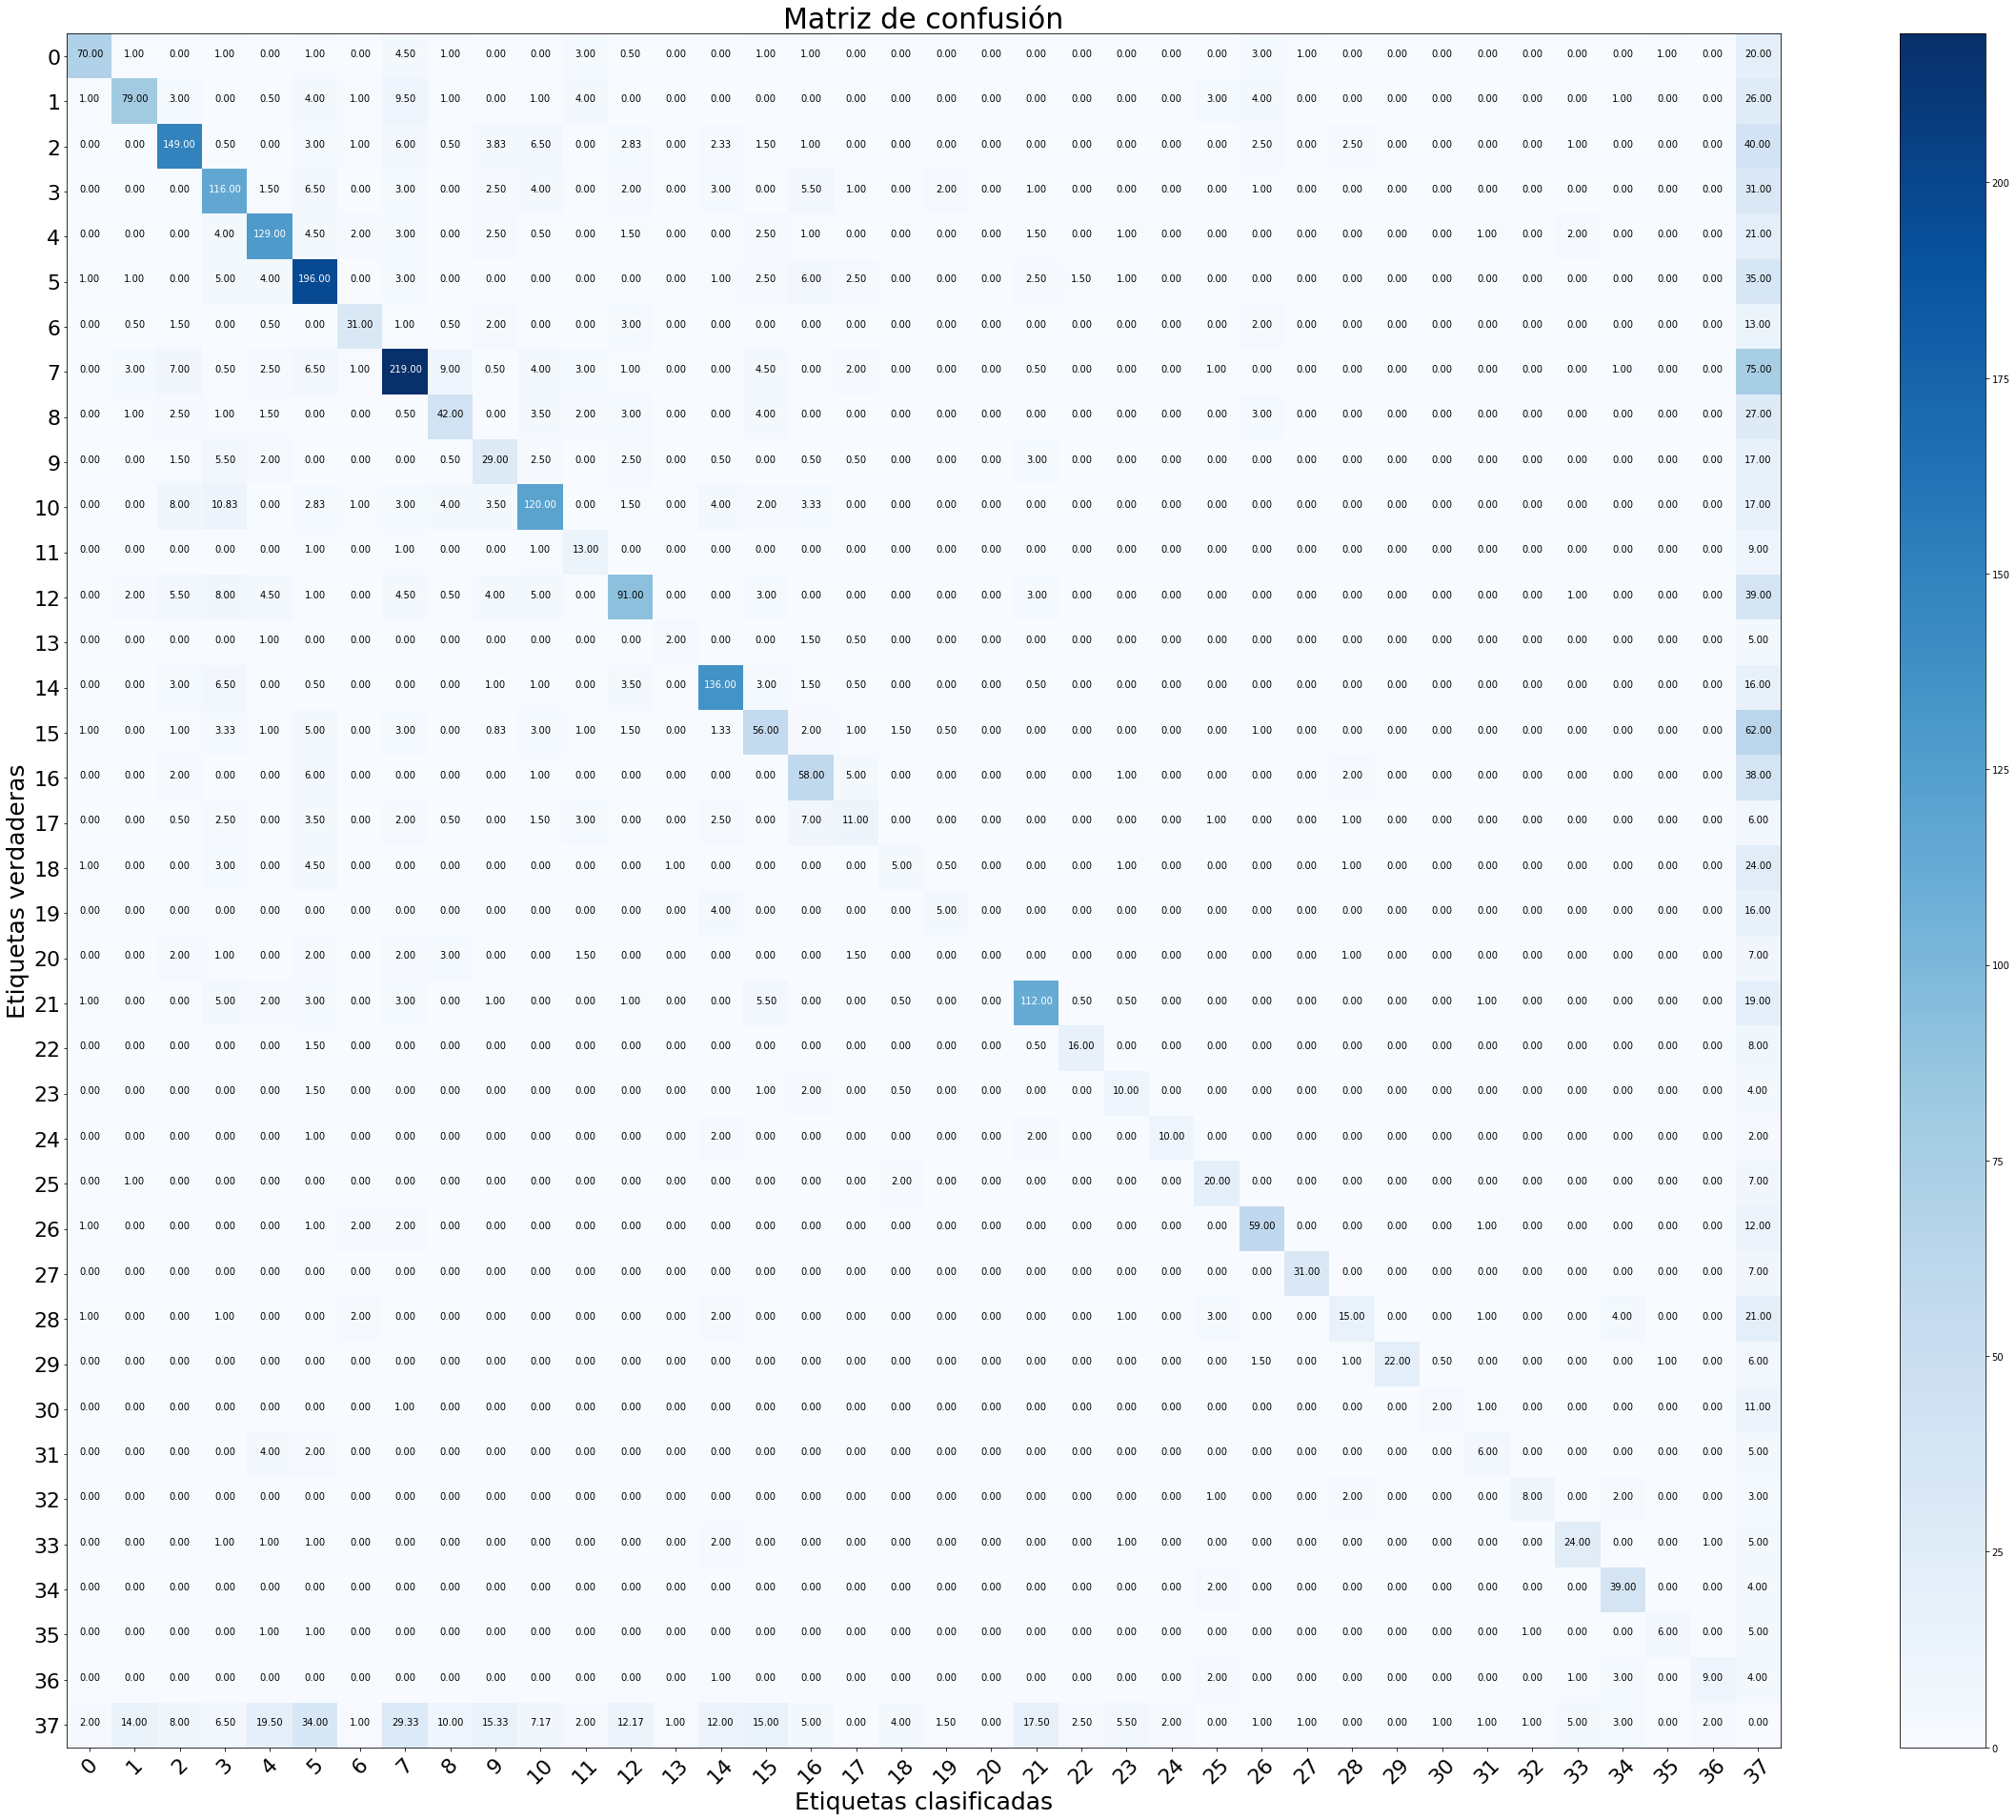

In [164]:
plot_confusion_matrix(matriZ,list(range(38)),normalize=False)